# Numerical vs Analytical Methods for DKI standard metrics

In this supplementary notebook, we compare the performance of the numerical and analytical methods to calculate DKI standard metrics using numerical simulations (noise free, section 1) and in vivo diffusion MRI acquisitions (section 2)

Let's import first the relevant modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reconstruction modules
import dipy.reconst.dki as dki
import dipy.reconst.msdki as msdki

# For simulations
from dipy.sims.voxel import multi_tensor
from dipy.core.gradients import gradient_table
from dipy.core.sphere import disperse_charges, HemiSphere

# For in-vivo data
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu

# Module for processing time calculation
from time import time

Let's also load a diffusion-weighted dataset and an object containing its acquisition parameters (these acquisition parameters will also be used for this notebook's simulations)

In [2]:
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')
data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

## 1) Simulations

As mentioned by [Tabesh et al. (2011)](https://pubmed.ncbi.nlm.nih.gov/21337412/) the analytical solutions to compute the axial, radial and mean kurtosis have some singularities, particularly for cases that the diffusion tensor has equal eigenvalues.

To illustrate theses singularities, below we run the simulations representing two crossing fibers (simulations case 4) that are repeated for different intersection angles. 

In [3]:
# Eigenvalues for the simulations
mevals = np.array([[1.4e-3, 0.1e-3, 0.1e-3],
                   [2e-3, 0.5e-3, 0.5e-3],
                   [1.4e-3, 0.1e-3, 0.1e-3],
                   [2e-3, 0.5e-3, 0.5e-3]])

# volume fraction between intra- and extra-cellular spaces
f_i = 50  #50

# estimating volume fractions for individual tensors
fractions = np.array([f_i, 100 - f_i, f_i, 100 - f_i]) * 0.5

# Array containing the intersection angle
ang = np.linspace(0, 90.0, num=901)

# Matrix where synthetic signals will be stored
dwi = np.empty((ang.size, bvals.size))

for a_i in range(ang.size):
    # defining the directions for individual tensors
    angles = [(ang[a_i], 0.0), (ang[a_i], 0.0), (0.0, 0.0), (0.0, 0.0)]

    # producing signals using Dipy's function multi_tensor
    signal, sticks = multi_tensor(gtab, mevals, S0=100, angles=angles,
                                  fractions=fractions, snr=None)
    dwi[a_i, :] = signal

Not let's compute dki statistics according to the numerical and analytical methods.

In [4]:
dki_model = dki.DiffusionKurtosisModel(gtab, fit_method='NLS')
dki_fit = dki_model.fit(dwi)

mk_ana = dki_fit.mk(0, 3, analytical=True)
mk_num = dki_fit.mk(0, 3, analytical=False)

rk_ana = dki_fit.rk(0, 3, analytical=True)
rk_num = dki_fit.rk(0, 3, analytical=False)

ak_ana = dki_fit.ak(0, 3, analytical=True)
ak_num = dki_fit.ak(0, 3, analytical=False)

dt_evals = dki_fit.evals 

To inspect which intersection angles are associated with singularities of the analytical model, below the plot the eigenvalues of the diffusion tensor as function of the intersection angle.

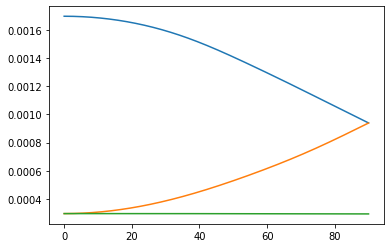

In [5]:
plt.plot(ang, dt_evals[:, 0])
plt.plot(ang, dt_evals[:, 1])
plt.plot(ang, dt_evals[:, 2])

From the figure above, we can detect two problematic cases for the analytical solutions:

1 - When intersection angle is zero (i.e. when the two fibers are aligned), the second diffusion eigenvalue is equal to the third eigenvalue. 

2 - When the intersection angle is 90 degrees, the first diffusion eigenvalue is equal to the second eigenvalue.

Let's now plot the analytical and numerical solutions for MK, AK and RK.

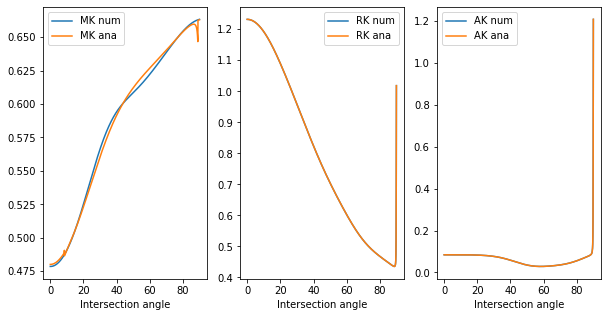

In [6]:
fig2, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axs[0].plot(ang, mk_num, label='MK num')
axs[0].plot(ang, mk_ana, label='MK ana')

axs[1].plot(ang, rk_num, label='RK num')
axs[1].plot(ang, rk_ana, label='RK ana')

axs[2].plot(ang, ak_num, label='AK num')
axs[2].plot(ang, ak_num, label='AK ana')

for ax_i in range(3):
    axs[ax_i].set_xlabel('Intersection angle')
    axs[ax_i].legend()
    

In general, both analytical and numerical methods produce identical calculations. However, for MK estimates of the analytical method some discontinuities of estimates can be observed for intersection near the singularities. These discontinuities can be associated to imprecisions on the selection of singularity cases (more information can be found on the following [link](http://gsoc2015dipydki.blogspot.com/2015/08/rnh-post-13-start-wrapping-up-test.html)).

## 2) In vivo data

Let's now compare the procedures on in vivo data kindly provided by Hansen and Jespersen (more details about the data are provided in their paper ([Hansen and Jespersen (2016)](https://www.nature.com/articles/sdata201672)). The processing time to run the analytical and numerical procedures are also estimated.

In [7]:
# Mask the data
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=True, dilate=1)
dkifit = dki_model.fit(maskdata, mask)

t = time()
# Let's time the processing time of each procedure
mk_ana = dkifit.mk(0, 3, analytical=True)
rk_ana = dkifit.rk(0, 3, analytical=True)
ak_ana = dkifit.ak(0, 3, analytical=True)
print("total time to process analytical solution", time() - t)

t = time()
# Let's time the processing time of each procedure
mk_num = dkifit.mk(0, 3, analytical=False)
rk_num = dkifit.rk(0, 3, analytical=False)
ak_num = dkifit.ak(0, 3, analytical=False)
print("total time to process numerical solution", time() - t)

C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dti.py:1727: RuntimeWarning: divide by zero encountered in true_divide
  params[vox, 12:] = this_param[6:-1] / md2
C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dki.py:2416: RuntimeWarning: invalid value encountered in add
  Wre = Wre + multiplyB * kt[..., ind_ele[key]]


total time to process analytical solution 6.301522493362427
total time to process numerical solution 41.50334310531616


From the computed processing times, one can note that our analytical solutions are faster to run than the numerical solutions. 

Below, let's plot the DKI maps obtained from both procedures:

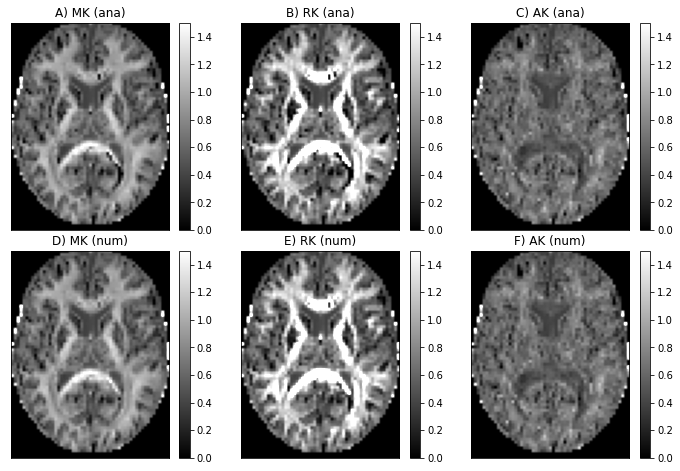

In [8]:
axial_slice = 10

fig, ax = plt.subplots(2, 3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.flat[0].set_title('A) MK (ana)')
imk = ax.flat[0].imshow(mk_ana[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')

ax.flat[1].set_title('B) RK (ana)')
ax.flat[1].imshow(rk_ana[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')

ax.flat[2].set_title('C) AK (ana)')
ax.flat[2].imshow(ak_ana[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')

ax.flat[3].set_title('D) MK (num)')
ax.flat[3].imshow(mk_num[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')

ax.flat[4].set_title('E) RK (num)')
ax.flat[4].imshow(rk_num[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')

ax.flat[5].set_title('F) AK (num)')
ax.flat[5].imshow(ak_num[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')

# add colorbars
a = 0
for lin in range(0, 3):
    for i in range(0, 2):
        fig.colorbar(imk, ax=ax.flat[a])
        a = a + 1

plt.show()
fig.savefig('Kurtosis_Metrics.png', bbox_inches='tight')

In practice, the two different strategies to compute standard kurtosis metrics present identical contrasts. Therefore, due to its faster processing, the analytical solution was chosen as the default in DIPY.